Test the rsults based on some Deterministic methods.

# Test the rules

In [1]:
from feature_selection import vectorize_by_compaction_output_level
from main import load_log_and_qps
from traversal import get_log_dirs, get_log_and_std_files
log_prefix_dir = "log_files"
dirs = get_log_dirs(log_prefix_dir)

In [2]:
log_dir = dirs[0]
stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

1599571593036903


In [3]:
import numpy as np
observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

In [4]:
# Use HMM to divide the data first

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from tensorflow_probability import  distributions as tfd
from matplotlib import pylab as plt

In [5]:
# Train the HMM states
fitting_area = observed_counts

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

    # Give probability exp(-100) ~= 0 to states outside of the current model.
    initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
    initial_state_logits[:num_states] = 0.
    initial_state_logits[0] = 1.
    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    transition_probs = np.eye(max_num_states, dtype=np.float32)
    if num_states > 1:
        transition_probs[:num_states, :num_states] = (
                daily_change_prob / (num_states - 1))
        np.fill_diagonal(transition_probs[:num_states, :num_states],
                         1 - daily_change_prob)
    return initial_state_logits, transition_probs

max_num_states=10
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states + 1):
    initial_state_logits, transition_probs = build_latent_state(
        num_states=num_states,
        max_num_states=max_num_states)
    batch_initial_state_logits.append(initial_state_logits)
    batch_transition_probs.append(transition_probs)
batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)

trainable_log_rates = tf.Variable(
    (np.log(np.mean(fitting_area)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
    name='log_rates')

hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=batch_initial_state_logits),
    transition_distribution=tfd.Categorical(probs=batch_transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(fitting_area))
rate_prior = tfd.LogNormal(5, 5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def log_prob():
    prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
    prior_lp = tf.stack(
        [tf.reduce_sum(prior_lps[i, :i + 1]) for i in range(max_num_states)])
    return prior_lp + hmm.log_prob(fitting_area)

@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)

for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print("step {}: loss {}".format(step, loss))


/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: loss [83466344. 30743974. 21666336. 21636434. 18812856. 12969982.  9395279.
  9387172.  9386466.  9376900.]
step 20: loss [81440090.  13191095.   8171021.5  4881338.   3720301.8  3211862.2
  2507950.5  2094692.6  1894605.4  1814702.1]
step 40: loss [81351260.  12381119.   7784547.   4698032.   3564643.5  2284550.
  1785494.4  1464617.6  1255424.9  1138594. ]
step 60: loss [81348900.  12303824.   7764033.5  4692682.   3259697.5  1933783.5
  1519201.   1243987.6  1039333.7   917266.3]
step 80: loss [81348600.   12286624.    7755355.    4668399.5   2935429.2   1795422.2
  1396121.9   1136728.2    935242.94   814008.75]
step 100: loss [81348130.   12285247.    7753559.5   4667020.    2776077.2   1719875.6
  1327703.8   1072868.6    871952.4    750238.44]
step 120: loss [81348370.   12285219.    7753484.5   4666634.    2697966.    1672334.5
  1282534.    1029647.06   828344.6    706876.1 ]
step 140: loss [81348184.   12285220.    7753495.5   4666585.    2651032.8   1638879.1
  12504

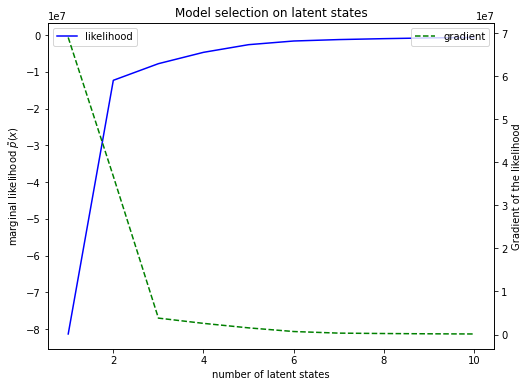

In [6]:
num_states = np.arange(1, max_num_states + 1)
fig = plt.figure(figsize=(8, 6))
plt.plot(num_states, -loss, "b-", label="likelihood")
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.legend()
plt.twinx()
plt.plot(num_states, np.gradient(-loss), "g--", label="gradient")
plt.ylabel("Gradient of the likelihood")
plt.title("Model selection on latent states")
plt.legend()
plt.show()

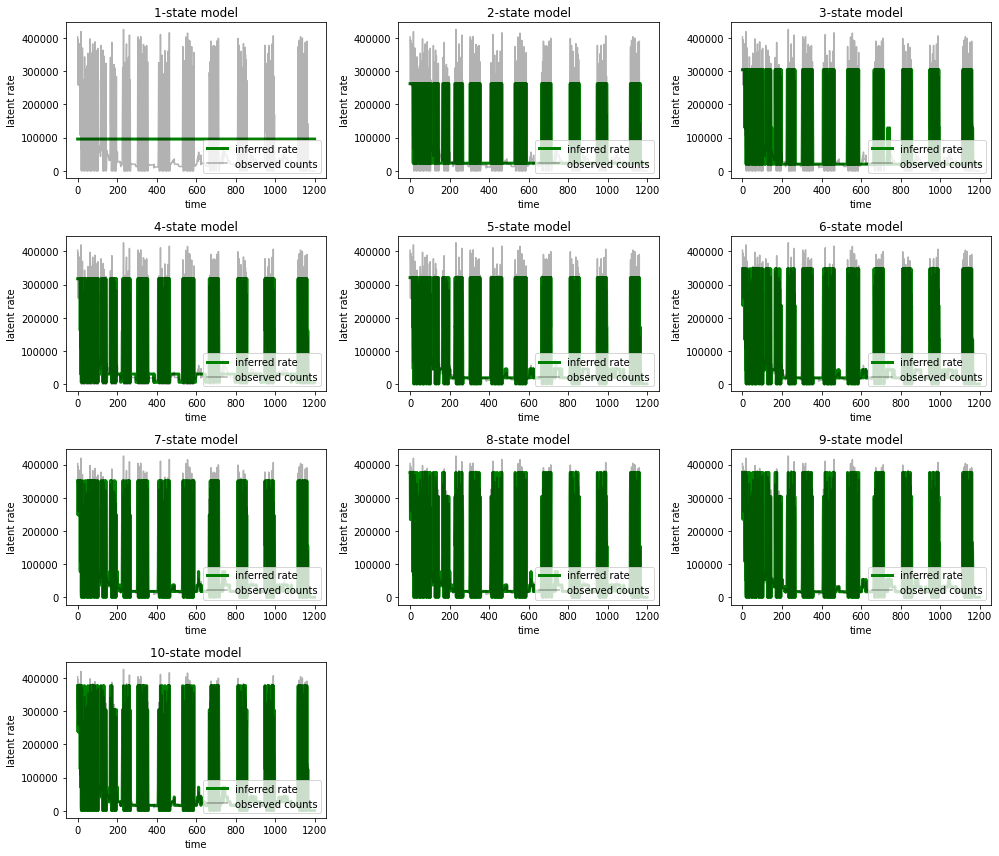

In [7]:
posterior_probs = hmm.posterior_marginals(
    fitting_area).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    ax = fig.add_subplot(4, 3, i + 1)
    ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
    ax.plot(fitting_area, c='black', alpha=0.3, label='observed counts')
    ax.set_ylabel("latent rate")
    ax.set_xlabel("time")
    ax.set_title("{}-state model".format(i + 1))
    ax.legend(loc=4)
plt.tight_layout()
plt.show()

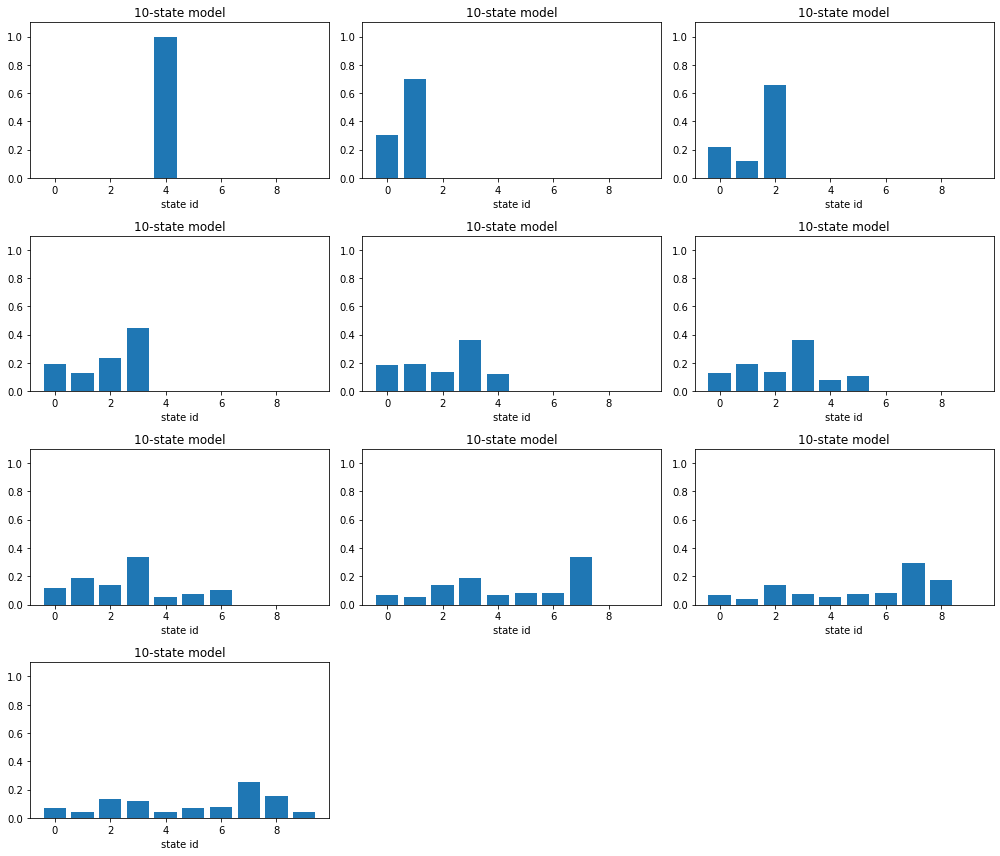

In [8]:
def autolabel(rects,infer_rates):
    """Attach a text label above each bar in *rects*, displaying its height."""
    index = 0
    for rect in rects:
        height = infer_rates[index]
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index+=1
    pass

fig = plt.figure(figsize=(14,12))
list_of_moment_map = []
for number_of_states in range(max_num_states):
    moment_map = {}
    ax = fig.add_subplot(4,3,number_of_states+1)
    for state_no in range(max_num_states):
        moment_map[state_no] = []

    index = 0
    for state in most_probable_states[number_of_states]:
        moment_map[state].append(index)
        index+=1
    # moment_map = {k:v for k,v in moment_map.items() if len(v) > 0}
    frequency_count = [len(moment_map[x]) / index for x in moment_map]
    bar1 = ax.bar(range(len(moment_map)),frequency_count)
    # autolabel(bar1,most_probable_states[number_of_states])
    ax.set_ylim(0,1.1)
    ax.set_xlabel("state id")
    ax.set_title("{}-state model".format(i + 1))
    list_of_moment_map.append(moment_map)
plt.tight_layout()
plt.show()

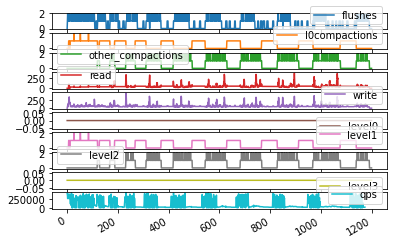

In [9]:
moment_map = list_of_moment_map[0]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

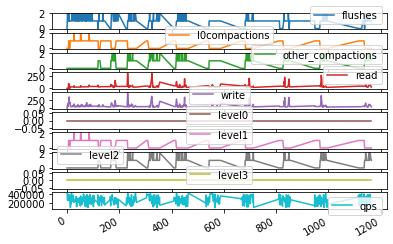

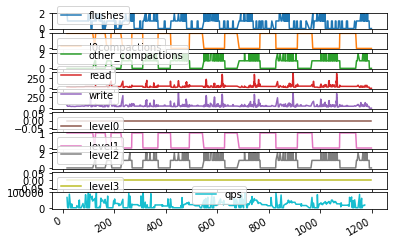

In [10]:
moment_map = list_of_moment_map[1]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

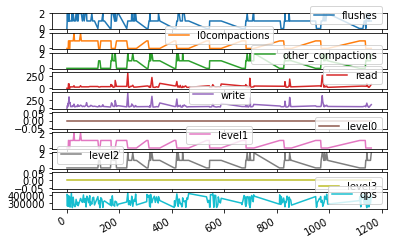

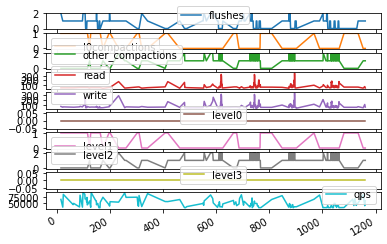

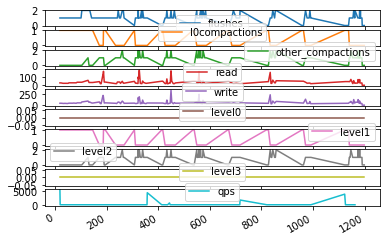

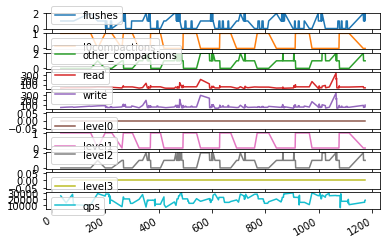

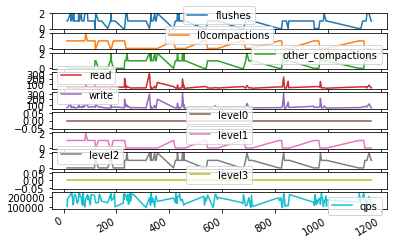

In [11]:
moment_map = list_of_moment_map[4]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

In [12]:
dirs[15]

def get_list_of_moment_map(fitting_area):
    def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

        # Give probability exp(-100) ~= 0 to states outside of the current model.
        initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
        initial_state_logits[:num_states] = 0.
        initial_state_logits[0] = 1.
        # Build a transition matrix that transitions only within the current
        # `num_states` states.
        transition_probs = np.eye(max_num_states, dtype=np.float32)
        if num_states > 1:
            transition_probs[:num_states, :num_states] = (
                    daily_change_prob / (num_states - 1))
            np.fill_diagonal(transition_probs[:num_states, :num_states],
                             1 - daily_change_prob)
        return initial_state_logits, transition_probs

    max_num_states=10
    batch_initial_state_logits = []
    batch_transition_probs = []
    for num_states in range(1, max_num_states + 1):
        initial_state_logits, transition_probs = build_latent_state(
            num_states=num_states,
            max_num_states=max_num_states)
        batch_initial_state_logits.append(initial_state_logits)
        batch_transition_probs.append(transition_probs)
    batch_initial_state_logits = np.array(batch_initial_state_logits)
    batch_transition_probs = np.array(batch_transition_probs)

    trainable_log_rates = tf.Variable(
        (np.log(np.mean(fitting_area)) *
         np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
         tf.random.normal([1, max_num_states])),
        name='log_rates')

    hmm = tfd.HiddenMarkovModel(
        initial_distribution=tfd.Categorical(
            logits=batch_initial_state_logits),
        transition_distribution=tfd.Categorical(probs=batch_transition_probs),
        observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
        num_steps=len(fitting_area))
    rate_prior = tfd.LogNormal(5, 5)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    def log_prob():
        prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
        prior_lp = tf.stack(
            [tf.reduce_sum(prior_lps[i, :i + 1]) for i in range(max_num_states)])
        return prior_lp + hmm.log_prob(fitting_area)

    @tf.function(autograph=False)
    def train_op():
        with tf.GradientTape() as tape:
            neg_log_prob = -log_prob()
        grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
        optimizer.apply_gradients([(grads, trainable_log_rates)])
        return neg_log_prob, tf.math.exp(trainable_log_rates)

    for step in range(201):
        loss, rates = [t.numpy() for t in train_op()]
        if step % 20 == 0:
            print("step {}: loss {}".format(step, loss))

    posterior_probs = hmm.posterior_marginals(
        fitting_area).probs_parameter().numpy()
    most_probable_states = np.argmax(posterior_probs, axis=-1)

    fig = plt.figure(figsize=(14, 12))
    for i, learned_model_rates in enumerate(rates):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
        ax.plot(fitting_area, c='black', alpha=0.3, label='observed counts')
        ax.set_ylabel("latent rate")
        ax.set_xlabel("time")
        ax.set_title("{}-state model".format(i + 1))
        ax.legend(loc=4)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(14,12))
    list_of_moment_map = []
    for number_of_states in range(max_num_states):
        moment_map = {}
        ax = fig.add_subplot(4,3,number_of_states+1)
        for state_no in range(max_num_states):
            moment_map[state_no] = []

        index = 0
        for state in most_probable_states[number_of_states]:
            moment_map[state].append(index)
            index+=1
        # moment_map = {k:v for k,v in moment_map.items() if len(v) > 0}
        frequency_count = [len(moment_map[x]) / index for x in moment_map]
        bar1 = ax.bar(range(len(moment_map)),frequency_count)
        # autolabel(bar1,most_probable_states[number_of_states])
        ax.set_ylim(0,1.1)
        ax.set_xlabel("state id")
        ax.set_title("{}-state model".format(i + 1))
        list_of_moment_map.append(moment_map)
    plt.tight_layout()
    plt.savefig("rate_frequency.png")
    plt.clf()

    return list_of_moment_map

1599560767685325
step 0: loss [12734083. 12734100. 12734118. 12734136. 12734153. 12734170. 12734186.
  6006603.  5121351.  5109713.]
step 20: loss [11350170.    7510141.5   3598295.2   1860373.1   1263150.5   1155929.6
  1112932.1   1064269.8    842836.8    690993.75]
step 40: loss [11351242.    5873786.    2147032.8   1362414.6    773265.9    567208.4
   535029.     512319.25   478300.25   368711.44]
step 60: loss [11347949.    5710206.5   1977688.1   1013510.44   675708.25   444732.66
   402654.34   388455.84   381512.22   266112.78]
step 80: loss [11347501.    5669070.    1942101.8    912276.3    584287.75   410307.
   371798.9    347372.2    345461.25   226018.52]
step 100: loss [11347405.    5656247.    1924090.4    893799.1    544398.25   395765.53
   358899.3    326581.47   325169.2    204766.38]
step 120: loss [11347469.    5649353.    1914834.     884774.56   537226.9    386827.7
   350427.72   313119.28   311741.16   191296.5 ]
step 140: loss [11347448.    5644987.5   1908726

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


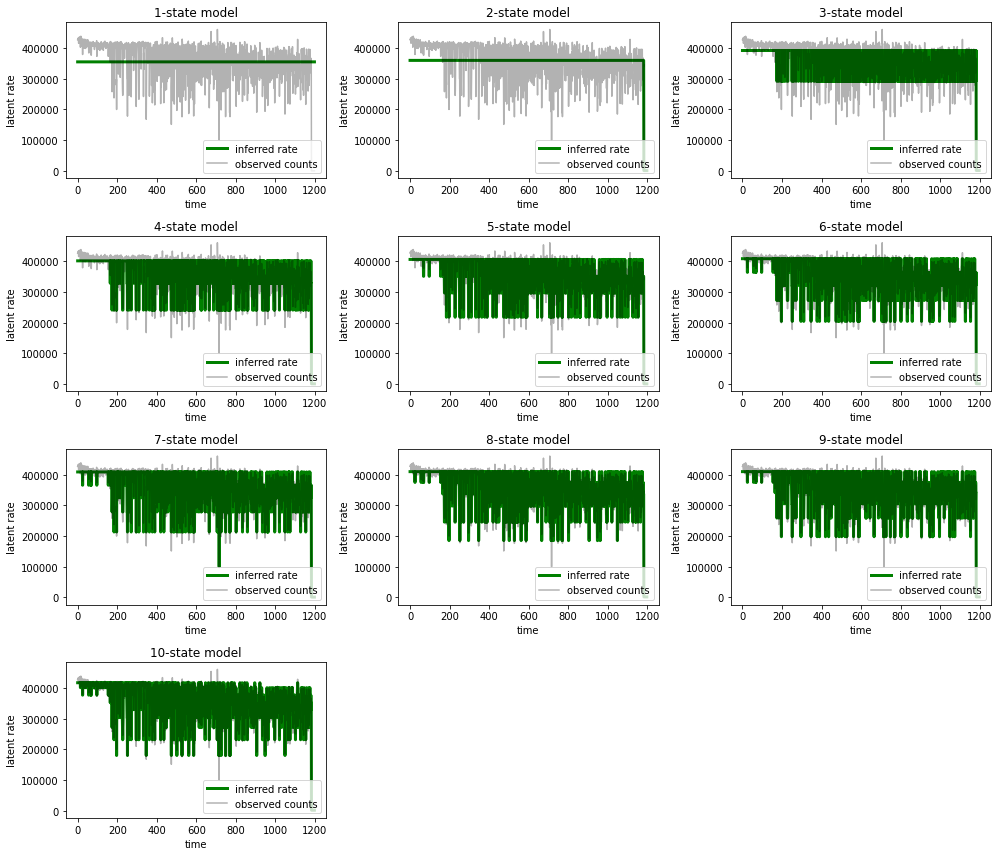

<Figure size 1008x864 with 0 Axes>

In [13]:
log_dir = dirs[15]
stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

list_of_moment_map = get_list_of_moment_map(observed_counts)

In [14]:
def plot_by_num_of_states(list_of_moment_map,num_of_states):
    moment_map = list_of_moment_map[num_of_states]

    for moment_list in moment_map:
        if len(moment_map[moment_list]) >0:
            # bucket_df[moment_map[moment_list]]
            selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
            selected_df.plot(subplots=True)
            # bucket_df["qps"][moment_map[moment_list]].plot()

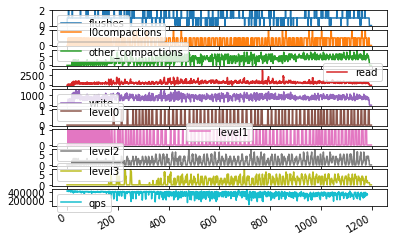

In [15]:
plot_by_num_of_states(list_of_moment_map,0)

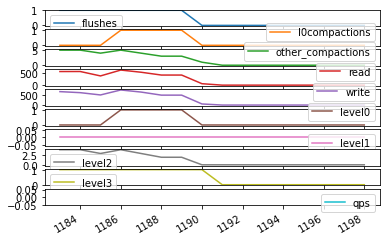

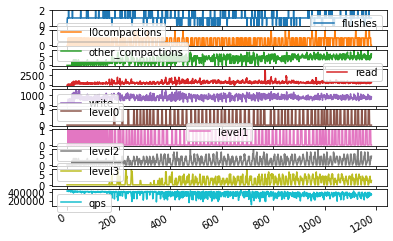

In [16]:
plot_by_num_of_states(list_of_moment_map,1)

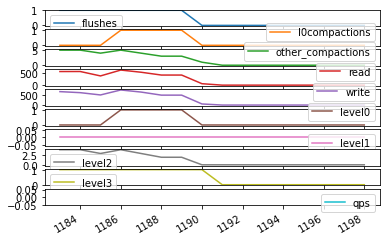

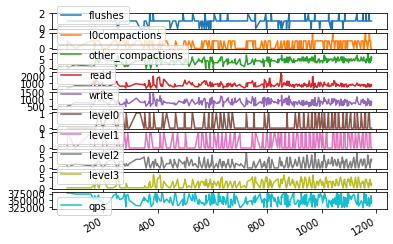

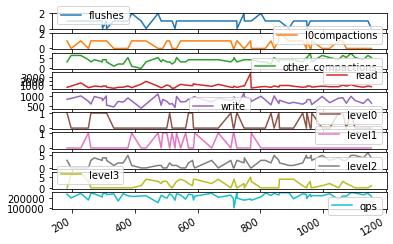

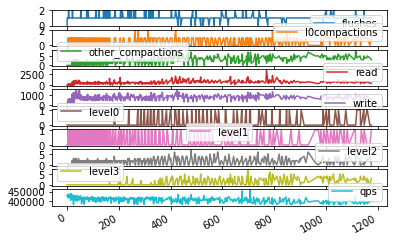

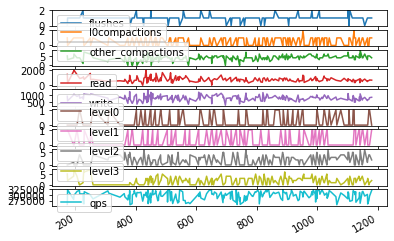

In [17]:
plot_by_num_of_states(list_of_moment_map,4)

1612149123624022
step 0: loss [34385070.  33945804.  20260594.  19796076.   7104476.   5059872.5
  4848658.   4832424.   4784812.5  4761858.5]
step 20: loss [34138664.    8834302.    4530681.5   3886575.5   1491321.5   1176533.4
  1096152.     997635.4    952773.56   936946.56]
step 40: loss [34138668.    6344643.5   2919193.    2064549.4    914160.8    729203.56
   568330.3    503449.66   455629.88   433354.2 ]
step 60: loss [34138656.    5833690.    2512427.5   1679762.8    791369.7    622939.
   436041.53   375153.34   330642.66   308033.9 ]
step 80: loss [34138590.    5651587.5   2357322.5   1493128.9    738178.2    578901.75
   379021.44   320563.6    276729.88   254213.4 ]
step 100: loss [34138652.    5572621.5   2282667.    1380052.2    706966.1    553208.94
   346708.5    289192.1    245544.47   223028.84]
step 120: loss [34138560.    5538376.    2241394.8   1309118.5    683302.94   533850.3
   325749.3    268560.8    224976.2    202461.95]
step 140: loss [34138544.    5523291.

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(
/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


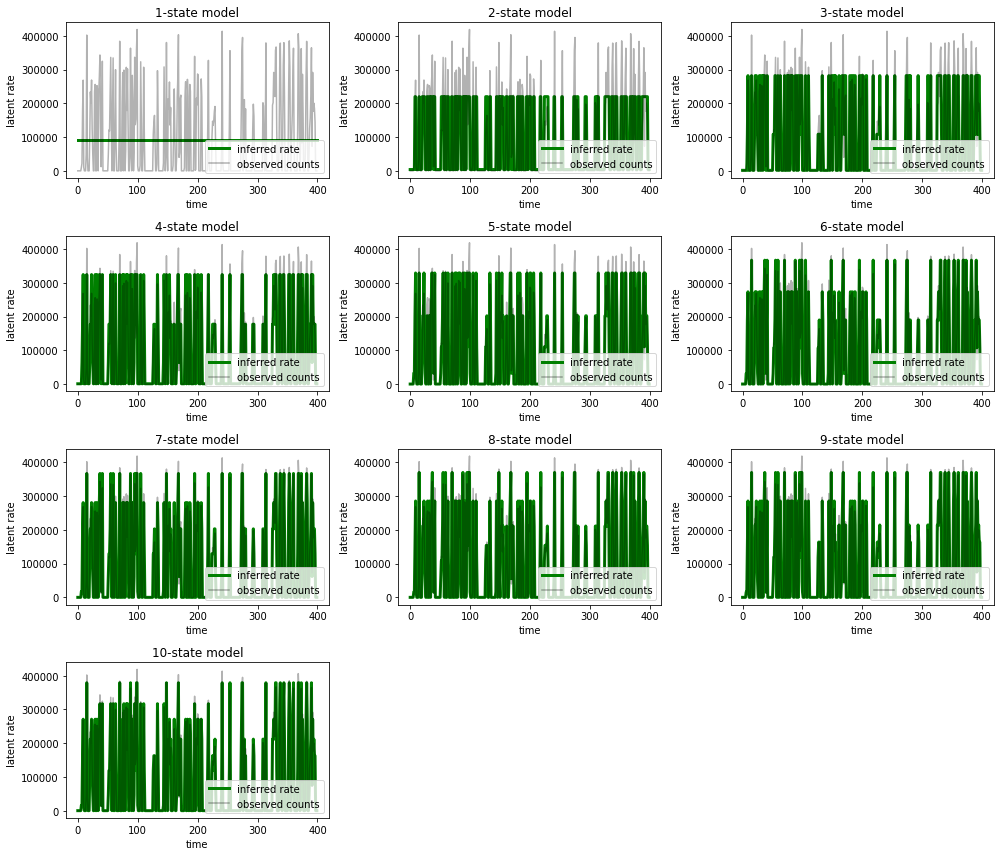

<Figure size 1008x864 with 0 Axes>

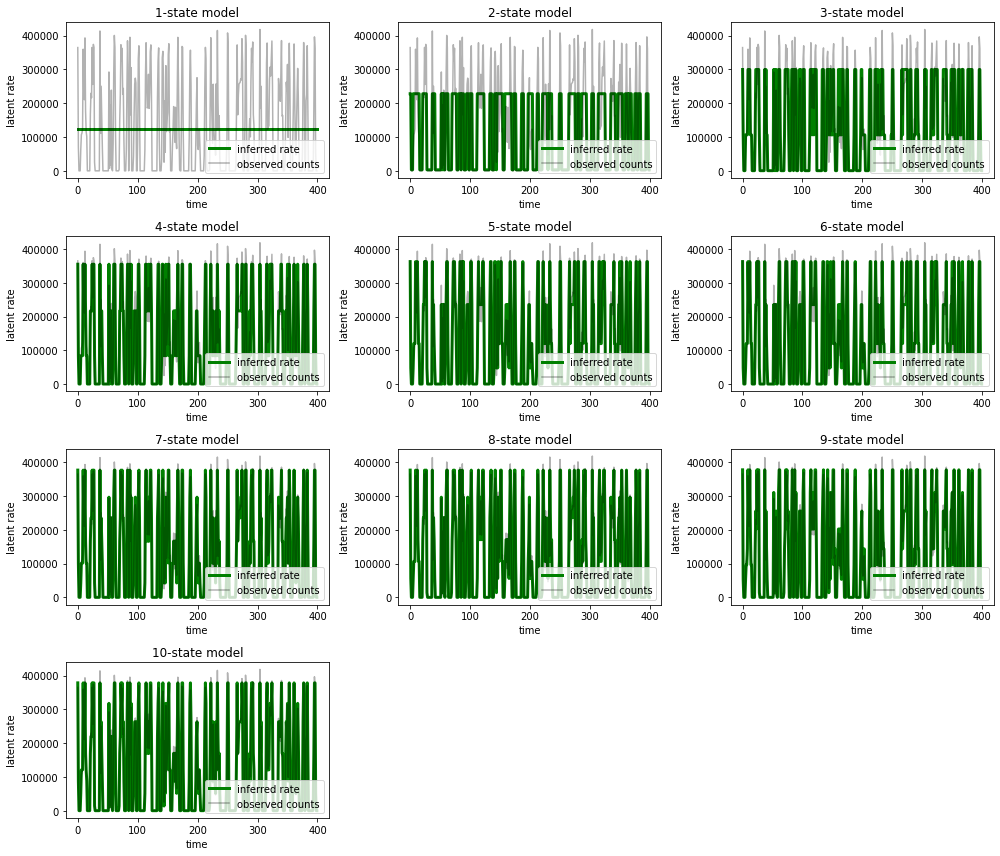

<Figure size 1008x864 with 0 Axes>

In [18]:
# Changing options while running
dirs = get_log_dirs("middle_changing_log")
log_dir = dirs[0]

stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

observation_before_changing = observed_counts[200:600]
observation_after_changing = observed_counts[610:1010]
list_of_moment_map_before_changing = get_list_of_moment_map(observation_before_changing)

list_of_moment_map_after_changing = get_list_of_moment_map(observation_after_changing)

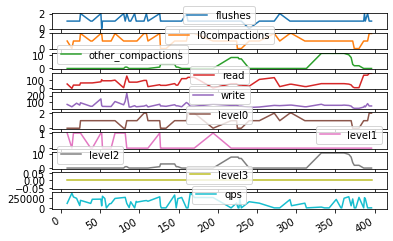

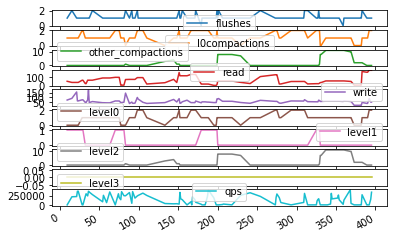

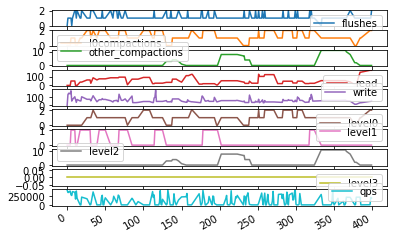

In [19]:
plot_by_num_of_states(list_of_moment_map_before_changing,2)

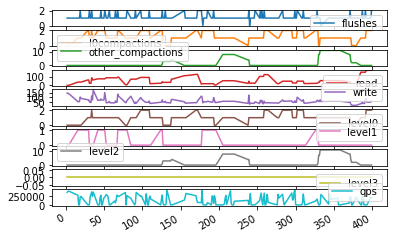

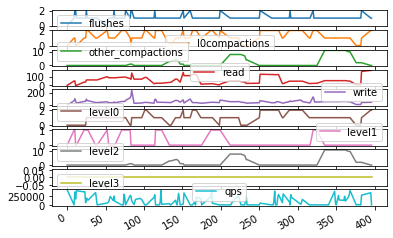

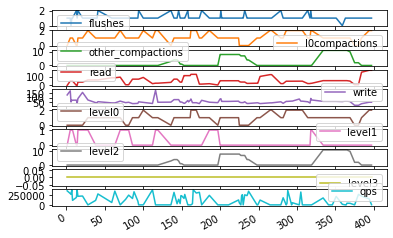

In [20]:
plot_by_num_of_states(list_of_moment_map_after_changing,2)

In [25]:
from sklearn.decomposition import PCA # for PCA calculation
filled_bucket = bucket_df.fillna(0)

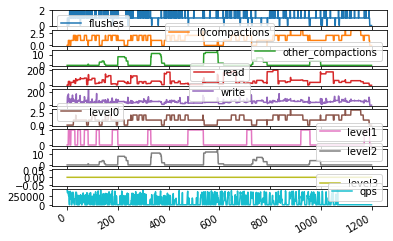

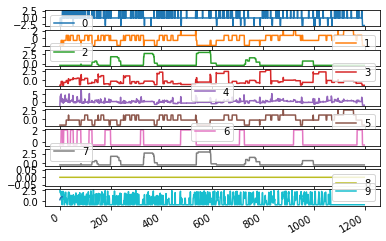

In [31]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
filled_bucket.plot(subplots=True)
X = filled_bucket.values
sc = StandardScaler()
X_std = sc.fit_transform(X)
pd.DataFrame(X_std).plot(subplots=True)

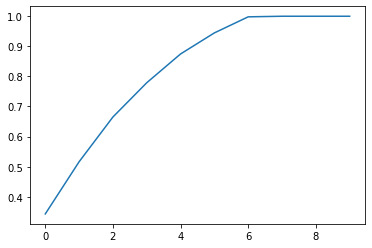

In [32]:
pca = PCA()
X_pca = pca.fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [39]:
num_components = 4
pca = PCA(num_components)
X_pca = pca.fit_transform(X_std)
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(X_std)

pd.DataFrame(pca.components_, columns = bucket_df.columns)
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = filled_bucket.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

most_important_names

['l0compactions', 'level1', 'write', 'qps', 'flushes', 'read', 'write']